# Testing for momentum budget fractional thickness multiplied diagnostics

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import xarray as xr
from xgcm import Grid
import dask 
import dask.distributed
%matplotlib inline

In [2]:
ppdir = "/work/Hemant.Khatri/MOM6_idealised/MOM_budget/Layer_SWM/2L/"

ds_mom = xr.open_dataset(ppdir + "TW_diag_test/mom.nc")
ds_prog = xr.open_dataset(ppdir + "TW_diag_test/prog.nc")
dsgrid = xr.open_dataset(ppdir + "ocean_month.nc")

ds = xr.merge([ds_mom, ds_prog, dsgrid])

In [3]:
ds

<xarray.Dataset>
Dimensions:           (Time: 6, xh: 400, xq: 400, yh: 200, yq: 200, zl: 2)
Coordinates:
  * Time              (Time) object 0011-01-09 00:00:00 ... 0021-04-06 00:00:00
  * xq                (xq) float64 4.0 8.0 12.0 ... 1.592e+03 1.596e+03 1.6e+03
  * yh                (yh) float64 2.0 6.0 10.0 14.0 ... 786.0 790.0 794.0 798.0
  * zl                (zl) float64 1.027e+03 1.028e+03
  * xh                (xh) float64 2.0 6.0 10.0 ... 1.59e+03 1.594e+03 1.598e+03
  * yq                (yq) float64 4.0 8.0 12.0 16.0 ... 788.0 792.0 796.0 800.0
Data variables:
    dudt              (Time, zl, yh, xq) float32 5.4909743e-09 ... nan
    dvdt              (Time, zl, yq, xh) float32 3.70199e-10 ... nan
    CAu               (Time, zl, yh, xq) float32 2.2456511e-08 ... nan
    CAv               (Time, zl, yq, xh) float32 3.7730285e-07 ... nan
    PFu               (Time, zl, yh, xq) float32 -2.6570126e-08 ... nan
    PFv               (Time, zl, yq, xh) float32 -3.910251e-07 ... 

In [4]:
grid = Grid(ds, coords={'X': {'center': 'xh', 'right': 'xq'},
                        'Y': {'center': 'yh', 'right': 'yq'} }, periodic=['X'])

In [5]:
H = ds['h'].sum('zl') 
h_frac = ds['h'] / H

h_fracu = grid.interp(h_frac,'X')
h_fracv = grid.interp(h_frac,'Y',boundary='fill')

Text(0, 0.5, 'y (km)')

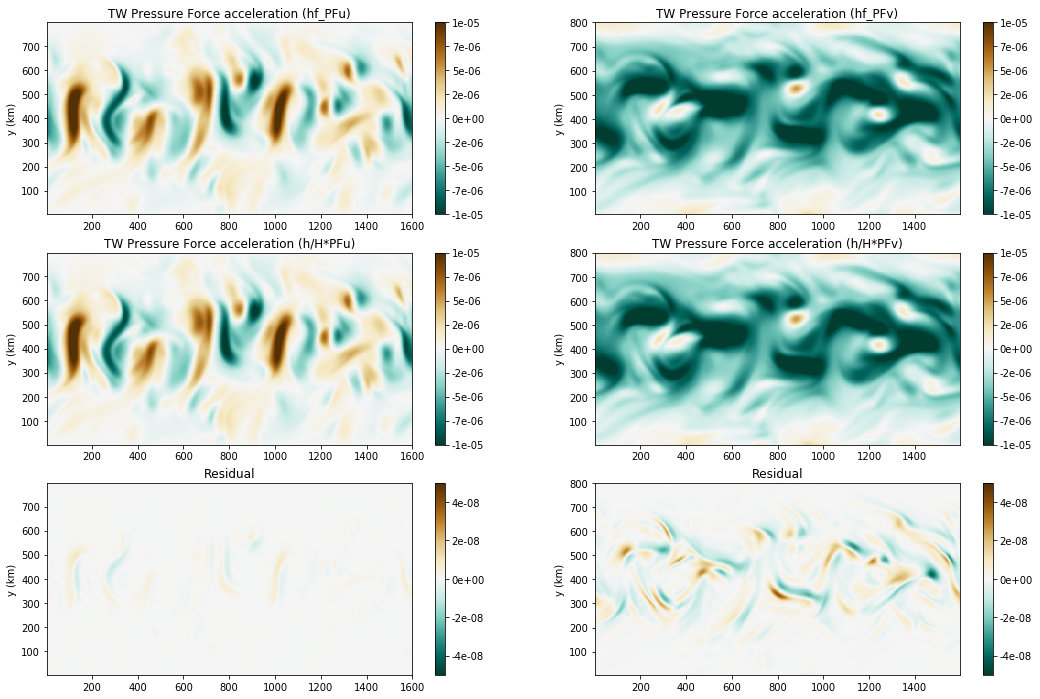

In [6]:
# Compare (h/H)Pfu and hf_Pfu (Snapshots)

tmp_PFu = h_fracu*ds['PFu']
tmp_PFv = h_fracv*ds['PFv']

idx = 2; i = 0
plt.figure(figsize=(18,12))
max_r = [1.e-5, 1.e-5]

plt.subplot(3,2,1)
plt.pcolor(ds['xq'], ds['yh'], ds['hf_PFu'].isel(Time=idx, zl=i), vmin = -max_r[i], vmax = max_r[i], cmap='BrBG_r')
plt.title('TW Pressure Force acceleration (hf_PFu)')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

plt.subplot(3,2,2)
plt.pcolor(ds['xh'], ds['yq'], ds['hf_PFv'].isel(Time=idx, zl=i), vmin = -max_r[i], vmax = max_r[i], cmap='BrBG_r')
plt.title('TW Pressure Force acceleration (hf_PFv)')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

plt.subplot(3,2,3)
plt.pcolor(ds['xq'], ds['yh'], tmp_PFu.isel(Time=idx, zl=i), vmin = -max_r[i], vmax = max_r[i], cmap='BrBG_r')
plt.title('TW Pressure Force acceleration (h/H*PFu)')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

plt.subplot(3,2,4)
plt.pcolor(ds['xh'], ds['yq'], tmp_PFv.isel(Time=idx, zl=i), vmin = -max_r[i], vmax = max_r[i], cmap='BrBG_r')
plt.title('TW Pressure Force acceleration (h/H*PFv)')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

plt.subplot(3,2,5)
plt.pcolor(ds['xq'], ds['yh'], (ds['hf_PFu']-tmp_PFu).isel(Time=idx, zl=i), vmin = -0.5e-2*max_r[i], vmax = 0.5e-2*max_r[i], cmap='BrBG_r')
plt.title('Residual')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

plt.subplot(3,2,6)
plt.pcolor(ds['xh'], ds['yq'], (ds['hf_PFv']-tmp_PFv).isel(Time=idx, zl=i), vmin = -0.5e-2*max_r[i], vmax = 0.5e-2*max_r[i], cmap='BrBG_r')
plt.title('Residual')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

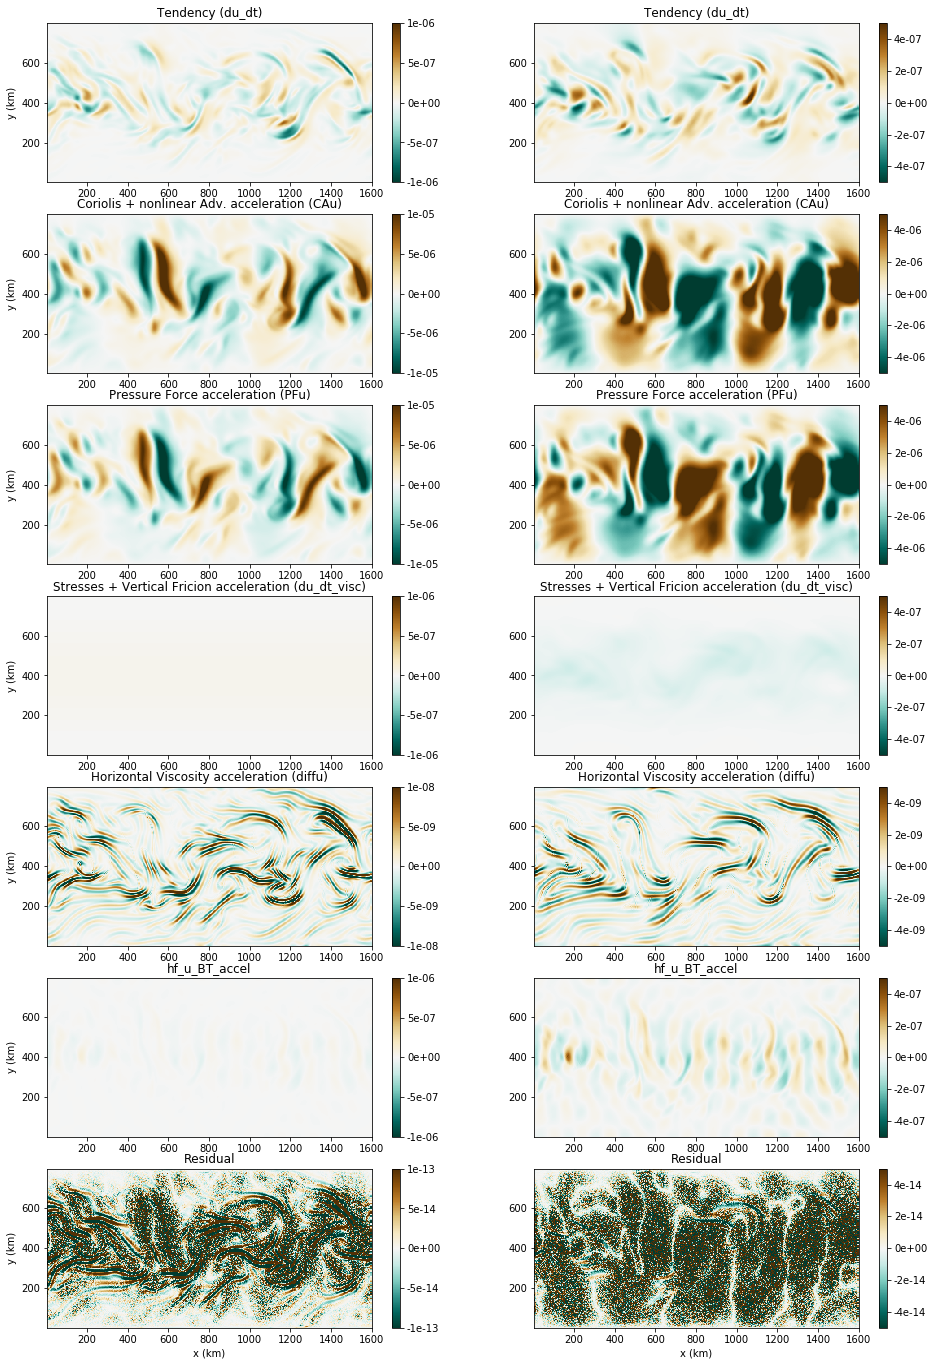

In [7]:
# Zonal Momentum budget
idx = 4
plt.figure(figsize=(16,24))
max_r = [1.e-6, 5.e-7]

for i in range(0,2):
    plt.subplot(7,2, i+1)
    plt.pcolormesh(ds['xq'], ds['yh'], ds['hf_dudt'].isel(Time=idx, zl=i), vmin = -max_r[i], 
             vmax = max_r[i], cmap='BrBG_r')
    plt.title('Tendency (du_dt)')
    plt.colorbar(format='%.0e')
    if(i==0):
        plt.ylabel('y (km)')
    
    plt.subplot(7,2, i+3)
    plt.pcolor(ds['xq'], ds['yh'], (ds['hf_CAu']).isel(Time=idx, zl=i), vmin = -1.e1*max_r[i], 
             vmax = 1.e1*max_r[i], cmap='BrBG_r')
    plt.title('Coriolis + nonlinear Adv. acceleration (CAu)')
    plt.colorbar(format='%.0e')
    if(i==0):
        plt.ylabel('y (km)')
    
    plt.subplot(7,2, i+5)
    plt.pcolor(ds['xq'], ds['yh'], ds['hf_PFu'].isel(Time=idx, zl=i), vmin = -1.e1*max_r[i], 
             vmax = 1.e1*max_r[i], cmap='BrBG_r')
    plt.title('Pressure Force acceleration (PFu)')
    plt.colorbar(format='%.0e')
    if(i==0):
        plt.ylabel('y (km)')
    
    plt.subplot(7,2, i+7)
    plt.pcolor(ds['xq'], ds['yh'], ds['hf_du_dt_visc'].isel(Time=idx, zl=i), vmin = -max_r[i], 
             vmax = max_r[i], cmap='BrBG_r')
    plt.title('Stresses + Vertical Fricion acceleration (du_dt_visc)')
    plt.colorbar(format='%.0e')
    if(i==0):
        plt.ylabel('y (km)')
    
    plt.subplot(7,2, i+9)
    plt.pcolor(ds['xq'], ds['yh'], ds['hf_diffu'].isel(Time=idx, zl=i), vmin = -1e-2*max_r[i], 
             vmax = 1e-2*max_r[i], cmap='BrBG_r')
    plt.title('Horizontal Viscosity acceleration (diffu)')
    plt.colorbar(format='%.0e')
    if(i==0):
        plt.ylabel('y (km)')
        
    plt.subplot(7,2, i+11)
    plt.pcolor(ds['xq'], ds['yh'], ds['hf_u_BT_accel'].isel(Time=idx, zl=i), vmin = -max_r[i], 
             vmax = max_r[i], cmap='BrBG_r')
    plt.title('hf_u_BT_accel')
    plt.colorbar(format='%.0e')
    if(i==0):
        plt.ylabel('y (km)')
    
    plt.subplot(7,2, i+13)
    plt.pcolor(ds['xq'], ds['yh'], (ds['hf_dudt']-ds['hf_CAu']-ds['hf_PFu']-ds['hf_diffu']-ds['hf_du_dt_visc']).isel(Time=idx, zl=i)
               - ds['hf_u_BT_accel'].isel(Time = idx, zl=i), vmin = -1e-7*max_r[i], vmax = 1e-7*max_r[i], cmap='BrBG_r')
    plt.xlabel('x (km)')
    plt.title('Residual')
    plt.colorbar(format='%.0e')
    if(i==0):
        plt.ylabel('y (km)')

Text(0.5, 0, 'x (km)')

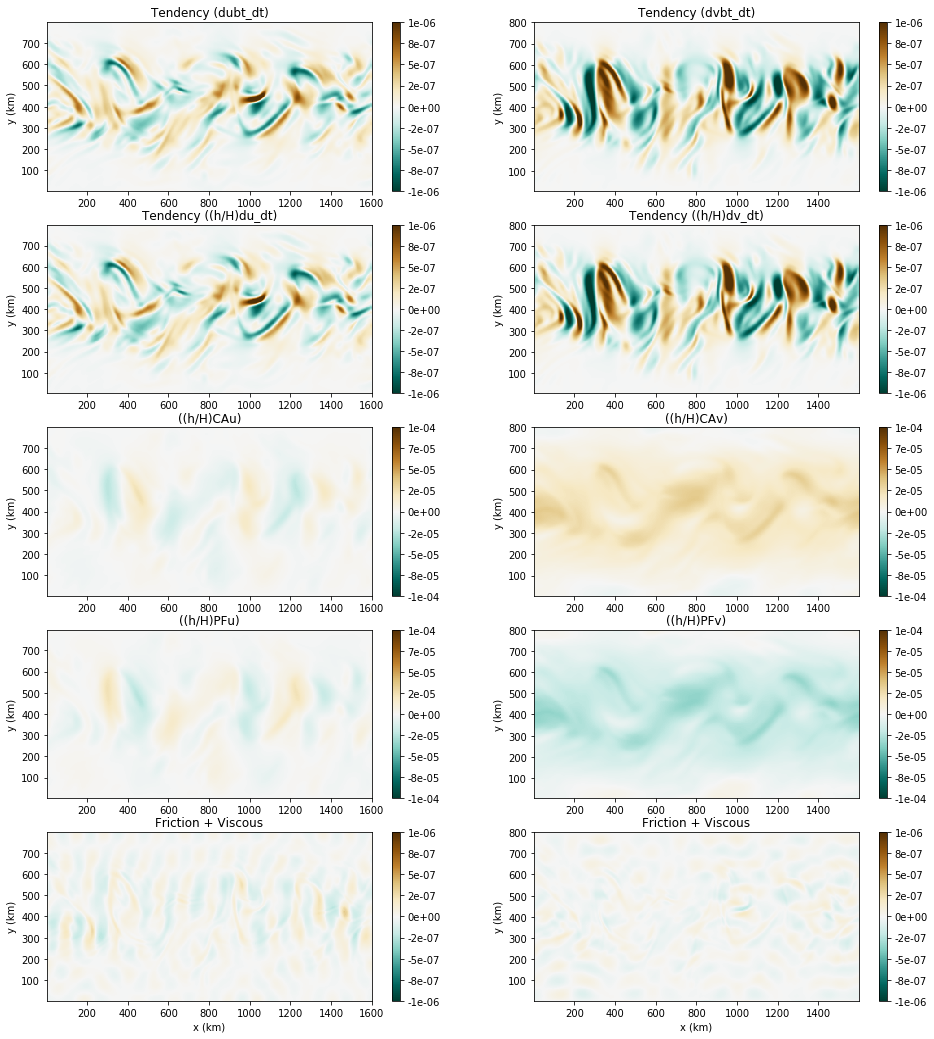

In [8]:
# Barotropic momentum budget

idx = 3

i = 0
plt.figure(figsize=(16,18))
max_r = [1.e-6, 1.e-6]

plt.subplot(5,2,1)
plt.pcolormesh(ds['xq'], ds['yh'], ds['ubt_dt'].isel(Time=idx), vmin = -max_r[i], vmax = max_r[i], cmap='BrBG_r')
plt.title('Tendency (dubt_dt)')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

plt.subplot(5,2,2)
plt.pcolormesh(ds['xh'], ds['yq'], ds['vbt_dt'].isel(Time=idx), vmin = -max_r[i], vmax = max_r[i], cmap='BrBG_r')
plt.title('Tendency (dvbt_dt)')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

plt.subplot(5,2,3)
plt.pcolormesh(ds['xq'], ds['yh'], ds['hf_dudt_2d'].isel(Time=idx), vmin = -max_r[i], vmax = max_r[i], cmap='BrBG_r')
plt.title('Tendency ((h/H)du_dt)')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

plt.subplot(5,2,4)
plt.pcolormesh(ds['xh'], ds['yq'], ds['hf_dvdt_2d'].isel(Time=idx), vmin = -max_r[i], vmax = max_r[i], cmap='BrBG_r')
plt.title('Tendency ((h/H)dv_dt)')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

plt.subplot(5,2,5)
plt.pcolormesh(ds['xq'], ds['yh'], ds['hf_CAu_2d'].isel(Time=idx), vmin = -1e2*max_r[i], vmax = 1e2*max_r[i], cmap='BrBG_r')
plt.title('((h/H)CAu)')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

plt.subplot(5,2,6)
plt.pcolormesh(ds['xh'], ds['yq'], ds['hf_CAv_2d'].isel(Time=idx), vmin = -1e2*max_r[i], vmax = 1e2*max_r[i], cmap='BrBG_r')
plt.title('((h/H)CAv)')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

plt.subplot(5,2,7)
plt.pcolormesh(ds['xq'], ds['yh'], ds['hf_PFu_2d'].isel(Time=idx), vmin = -1e2*max_r[i], vmax = 1e2*max_r[i], cmap='BrBG_r')
plt.title('((h/H)PFu)')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

plt.subplot(5,2,8)
plt.pcolormesh(ds['xh'], ds['yq'], ds['hf_PFv_2d'].isel(Time=idx), vmin = -1e2*max_r[i], vmax = 1e2*max_r[i], cmap='BrBG_r')
plt.title('((h/H)PFv)')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

plt.subplot(5,2,9)
plt.pcolormesh(ds['xq'], ds['yh'], (ds['hf_du_dt_visc_2d'] + ds['hf_diffu_2d'] +ds['hf_u_BT_accel_2d']).isel(Time=idx), 
               vmin = -max_r[i], vmax = max_r[i], cmap='BrBG_r')
plt.title('Friction + Viscous')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

plt.xlabel('x (km)')

plt.subplot(5,2,10)
plt.pcolormesh(ds['xh'], ds['yq'], (ds['hf_dv_dt_visc_2d'] + ds['hf_diffv_2d'] +ds['hf_v_BT_accel_2d']).isel(Time=idx),
               vmin = -max_r[i], vmax = max_r[i], cmap='BrBG_r')
plt.title('Friction + Viscous')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

plt.xlabel('x (km)')

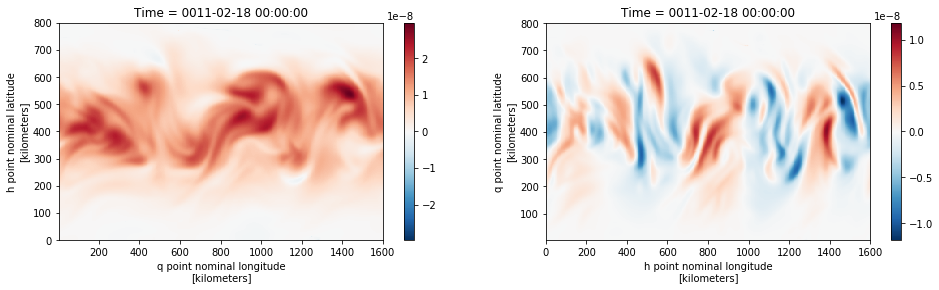

In [9]:
idx = 4
plt.figure(figsize=(16,4))

plt.subplot(1,2,1)
(ds['ubt_dt'] - ds['hf_dudt_2d']).isel(Time=idx).plot()

plt.subplot(1,2,2)
(ds['vbt_dt'] - ds['hf_dvdt_2d']).isel(Time=idx).plot()

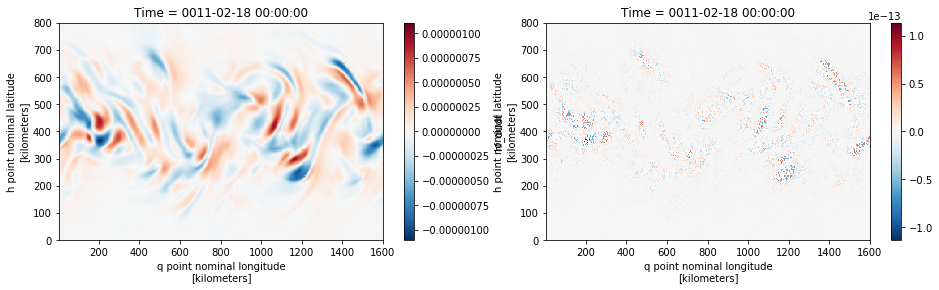

In [10]:
idx = 4
plt.figure(figsize=(16,4))

plt.subplot(1,2,1)
ds['hf_dudt'].isel(Time=idx).sum('zl').plot()

plt.subplot(1,2,2)
(ds['hf_dudt'].isel(Time=idx).sum('zl') - ds['hf_dudt_2d'].isel(Time=idx)).plot()

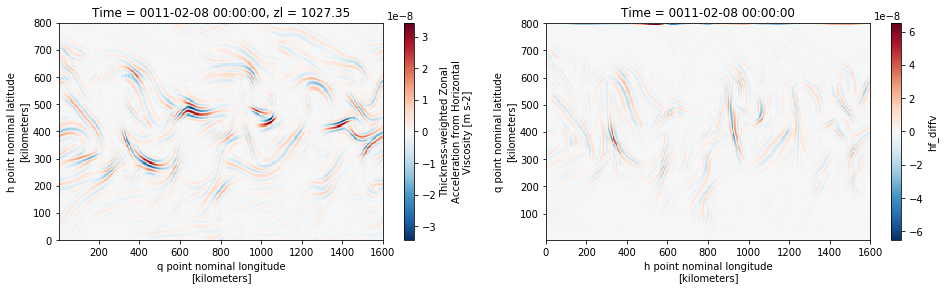

In [28]:
idx = 4
plt.figure(figsize=(16,4))

plt.subplot(1,2,1)
ds['hf_diffu'].isel(Time=3, zl=0).plot()

plt.subplot(1,2,2)
ds['hf_diffv'].isel(Time=3).sum('zl').plot()

Text(0, 0.5, 'y (km)')

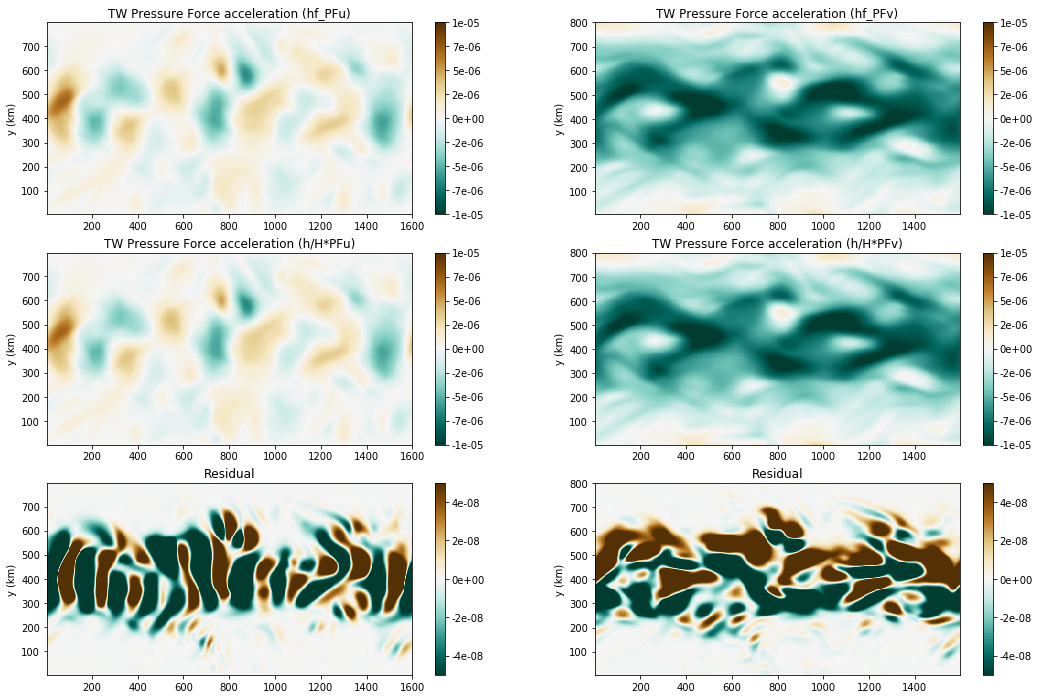

In [25]:
# Compare (h/H)Pfu and hf_Pfu (10-day averaged fields)
# These do not match well. This shows why we should prefer to compute diagnostics online.

tmp_PFu = h_fracu*ds['PFu']
tmp_PFv = h_fracv*ds['PFv']

idx = 2; i = 0
plt.figure(figsize=(18,12))
max_r = [1.e-5, 1.e-5]

plt.subplot(3,2,1)
plt.pcolor(ds['xq'], ds['yh'], ds['hf_PFu'].isel(Time=idx, zl=i), vmin = -max_r[i], vmax = max_r[i], cmap='BrBG_r')
plt.title('TW Pressure Force acceleration (hf_PFu)')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

plt.subplot(3,2,2)
plt.pcolor(ds['xh'], ds['yq'], ds['hf_PFv'].isel(Time=idx, zl=i), vmin = -max_r[i], vmax = max_r[i], cmap='BrBG_r')
plt.title('TW Pressure Force acceleration (hf_PFv)')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

plt.subplot(3,2,3)
plt.pcolor(ds['xq'], ds['yh'], tmp_PFu.isel(Time=idx, zl=i), vmin = -max_r[i], vmax = max_r[i], cmap='BrBG_r')
plt.title('TW Pressure Force acceleration (h/H*PFu)')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

plt.subplot(3,2,4)
plt.pcolor(ds['xh'], ds['yq'], tmp_PFv.isel(Time=idx, zl=i), vmin = -max_r[i], vmax = max_r[i], cmap='BrBG_r')
plt.title('TW Pressure Force acceleration (h/H*PFv)')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

plt.subplot(3,2,5)
plt.pcolor(ds['xq'], ds['yh'], (ds['hf_PFu']-tmp_PFu).isel(Time=idx, zl=i), vmin = -0.5e-2*max_r[i], vmax = 0.5e-2*max_r[i], cmap='BrBG_r')
plt.title('Residual')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

plt.subplot(3,2,6)
plt.pcolor(ds['xh'], ds['yq'], (ds['hf_PFv']-tmp_PFv).isel(Time=idx, zl=i), vmin = -0.5e-2*max_r[i], vmax = 0.5e-2*max_r[i], cmap='BrBG_r')
plt.title('Residual')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

In [13]:
ds.close()